In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [39]:
data_dir='/data_local/mbhosale/PathDiff/PathLDM/PanNuke/'

In [40]:

#load image npy
data_dir='/data_local/mbhosale/PathDiff/PathLDM/PanNuke/'
image_1=np.load(os.path.join(data_dir, "Part1/images.npy"),mmap_mode='r')
masks_1=np.load(os.path.join(data_dir, "Part1/masks.npy"),mmap_mode='r')
types_1=np.load(os.path.join(data_dir, "Part1/types.npy"),mmap_mode='r')
image_2=np.load(os.path.join(data_dir,"Part2/images.npy"),mmap_mode='r')
masks_2=np.load(os.path.join(data_dir,"Part2/masks.npy"),mmap_mode='r')
types_2=np.load(os.path.join(data_dir,"Part2/types.npy"),mmap_mode='r')
image_3=np.load(os.path.join(data_dir,"Part3/images.npy"),mmap_mode='r')
masks_3=np.load(os.path.join(data_dir,"Part3/masks.npy"),mmap_mode='r')
types_3=np.load(os.path.join(data_dir,"Part3/types.npy"),mmap_mode='r')

In [41]:
# Convert the masks to a single channel
def convert_3d_mask_to_2d(mask_3d): # PanNuke dataset where first five channels are types of different nuclei instance segemntation, last chanel is background.
    """
    Convert a 3D mask to a 2D mask.
    
    For each pixel, if it has a non-zero value in the first five channels of the 3D mask,
    the corresponding value in the 2D mask will be set to the channel number (1-5).
    If no non-zero value is found in the first five channels, it's set to 255.
    
    Parameters:
    mask_3d (numpy.ndarray): A 3D numpy array of shape (256, 256, 6)
    
    Returns:
    numpy.ndarray: A 2D numpy array of shape (256, 256)
    """
    # Check if the mask_3d has the correct shape
    if mask_3d.shape != (256, 256, 6):
        raise ValueError("Input mask must have shape (256, 256, 6)")

    # Initialize the 2D mask with all 255s
    mask_2d = np.full((256, 256), 6, dtype=np.uint8)

    # Iterate over each channel and update the 2D mask
    for channel in range(5):  # Only considering the first five channels
        mask_2d[(mask_3d[:, :, channel] != 0) & (mask_2d == 6)] = channel + 1

    return mask_2d

#### Visualize the masks

In [42]:
np.unique(masks_1[0]) 

array([ 0.,  1.,  3., 18., 19., 28., 31., 38., 40., 41.])

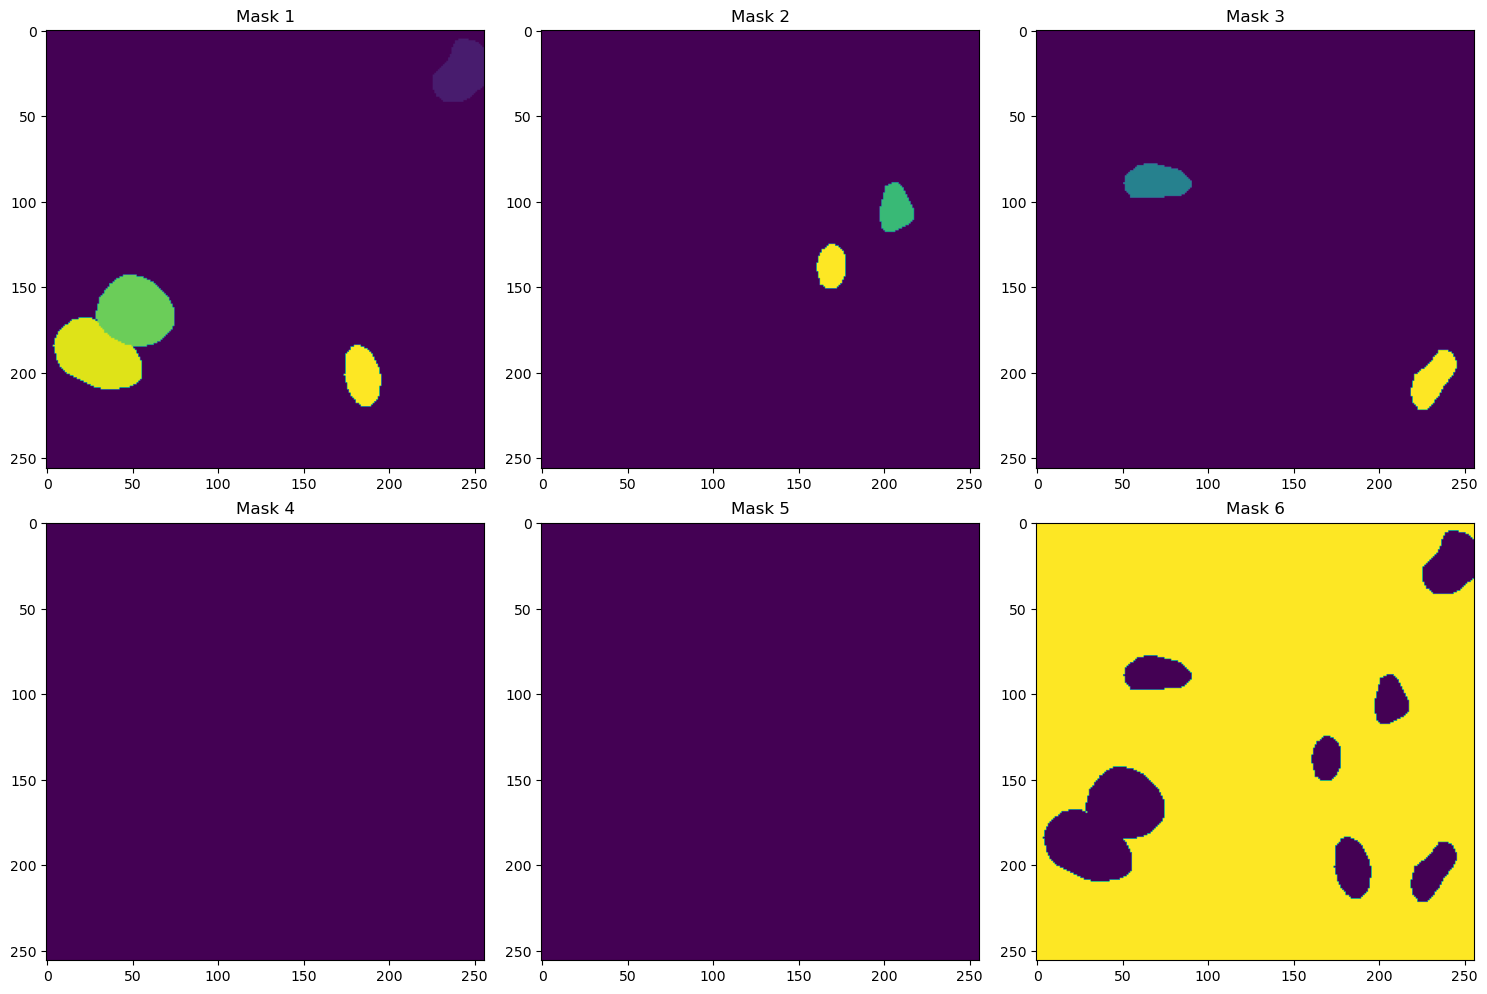

In [9]:
img_idx = 0
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Flattening the axes array for easier iteration
axes = axes.flatten()

for i in range(0, 6):
    axes[i].imshow(masks_1[img_idx][:, :, i])
    axes[i].set_title(f'Mask {i+1}')  # Set title with mask number
plt.tight_layout()
plt.show()

In [43]:
# concatenate images
images = np.concatenate((image_1, image_2, image_3), axis=0)

In [44]:
masks = np.concatenate((masks_1, masks_2, masks_3), axis=0)

In [45]:
from tqdm import tqdm
new_masks = []
old_masks = [masks_1, masks_2, masks_3] 
for i in range(len(old_masks)):
    print(f"Processing mask {i+1}")
    masks = old_masks[i]
    for mask in tqdm(masks):
        mask = convert_3d_mask_to_2d(mask)
        new_masks.append(mask)
new_masks = np.array(new_masks) # Convert the list to a numpy array
assert new_masks.shape == (images.shape[:-1])  # Check the shape

Processing mask 1


100%|██████████| 2656/2656 [00:01<00:00, 2082.23it/s]


Processing mask 2


100%|██████████| 2523/2523 [00:01<00:00, 2139.49it/s]


Processing mask 3


100%|██████████| 2722/2722 [00:01<00:00, 2134.05it/s]


In [53]:
def convert_mask_to_rgb(mask):
    # Ensure the mask is a 2D array
    assert len(mask.shape) == 2, "Input mask must be a 2D array"
    
    # Stack the single-channel mask to create a 3-channel RGB image
    rgb_mask = np.stack([mask]*3, axis=-1)
    
    return rgb_mask

In [56]:
rgb_mask = convert_mask_to_rgb(new_masks[0])

In [63]:
import cv2
def apply_colormap_to_mask(mask, colormap=cv2.COLORMAP_JET):
    assert len(mask.shape) == 2, "Input mask must be a 2D array"
    mask_normalized = cv2.normalize(mask, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    colored_mask = cv2.applyColorMap(mask_normalized, colormap)
    
    return colored_mask


In [65]:
rgb_mask2 = apply_colormap_to_mask(new_masks[0])

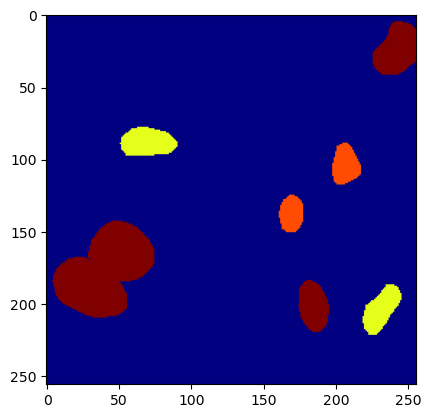

In [68]:
plt.imshow(rgb_mask2, vmax=255, vmin=0)

In [6]:
# concatenate types
types = np.concatenate((types_1, types_2, types_3), axis=0)

<Axes: xlabel='type'>

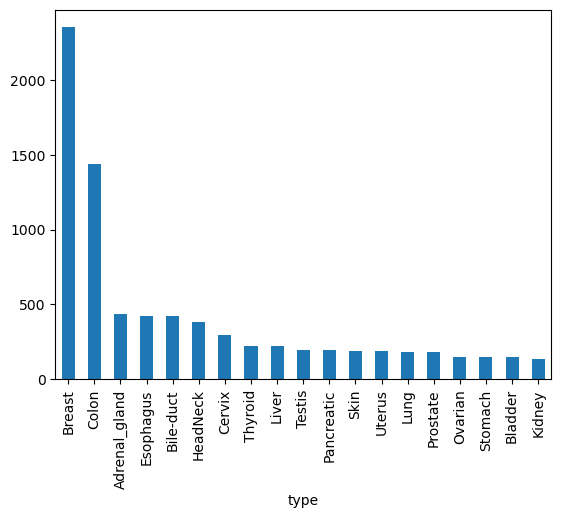

In [7]:
types_df = pd.DataFrame(types, columns=['type'])
types_df['type'].value_counts().plot(kind='bar')

In [8]:
#Change the dtype to int to show the image
images=images.astype('int32')
new_masks=new_masks.astype('int32')

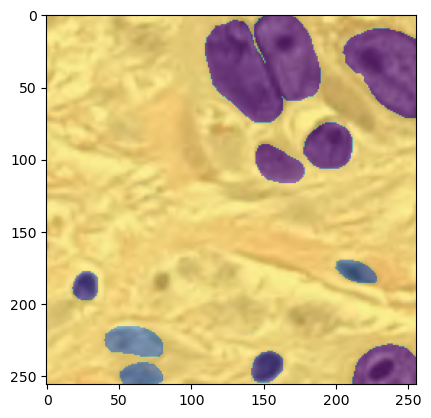

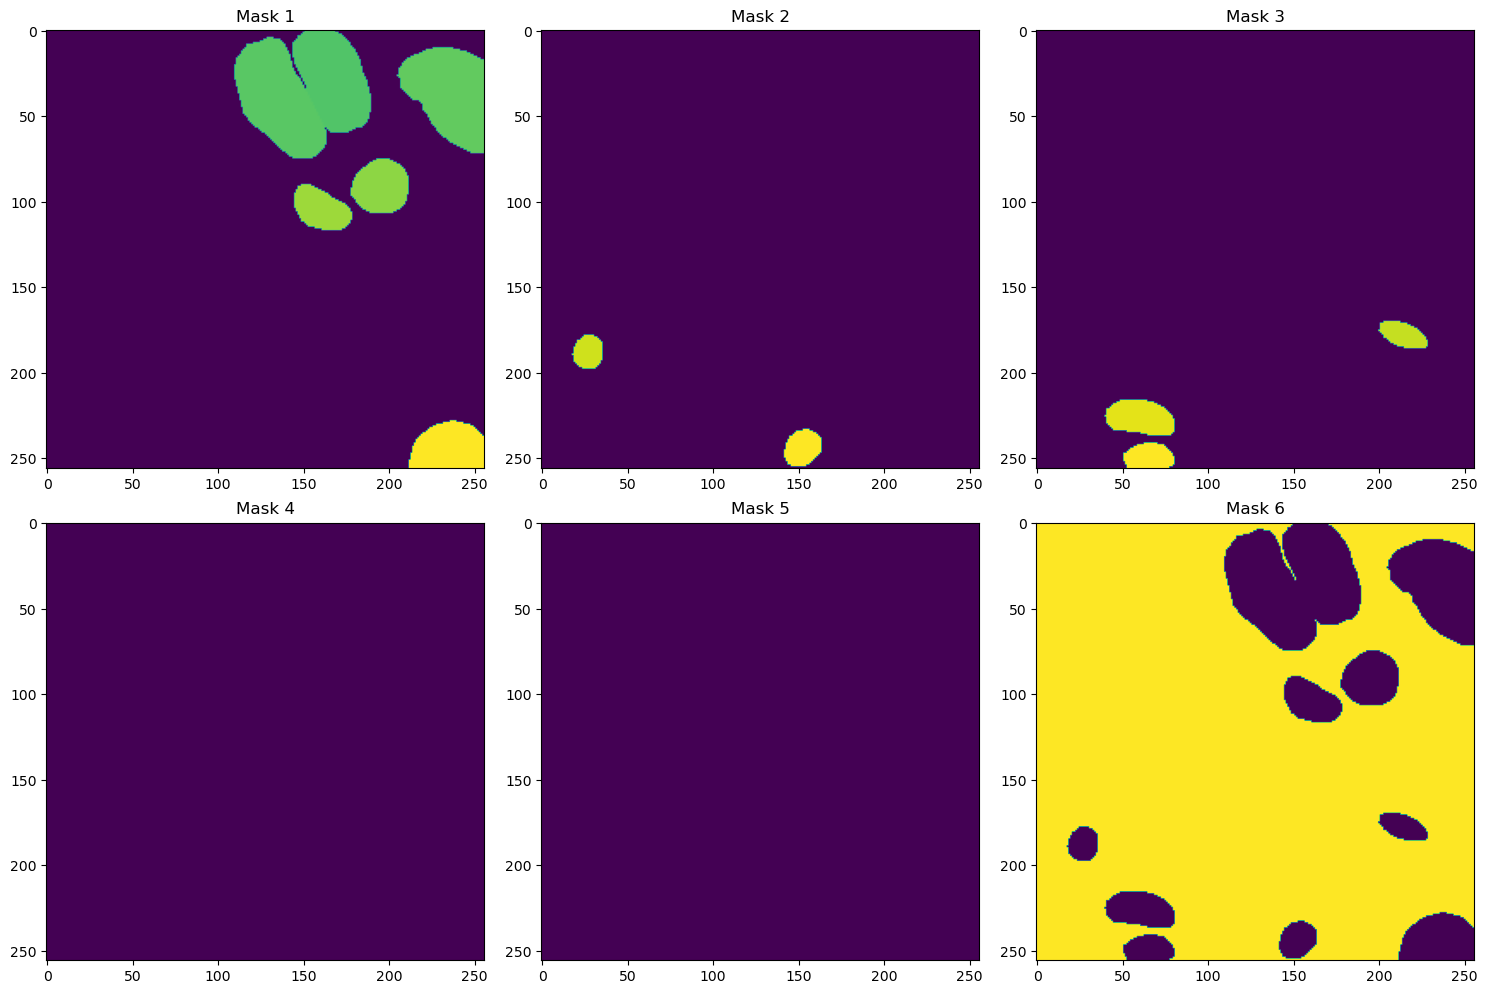

In [10]:
img_idx = 35
plt.imshow(images[img_idx]) 
plt.imshow(new_masks[img_idx], alpha=0.5)  # Overlay the mask on the image
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Flattening the axes array for easier iteration
axes = axes.flatten()

for i in range(0, 6):
    axes[i].imshow(masks[img_idx][:, :, i])
    axes[i].set_title(f'Mask {i+1}')  # Set title with mask number
plt.tight_layout()
plt.show()

In [11]:
# train and test split
import numpy as np
from sklearn.model_selection import train_test_split
images_train, images_test, masks_train, masks_test, types_train, types_test = train_test_split(
    images, new_masks, types, test_size=0.2, random_state=42)

# Print the shapes of the train and test sets
print("Train set shapes:")
print("Images:", images_train.shape)
print("Masks:", masks_train.shape)
print("Types:", types_train.shape)

print("\nTest set shapes:")
print("Images:", images_test.shape)
print("Masks:", masks_test.shape)
print("Types:", types_test.shape)


: 

TypeError: Invalid shape (256, 256, 6) for image data

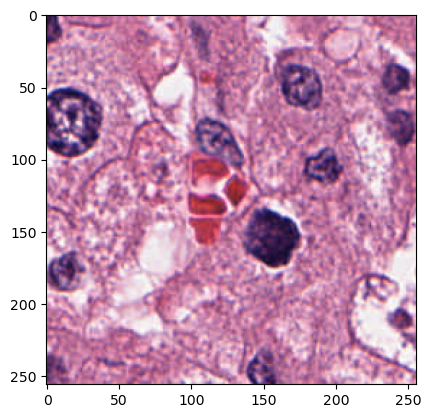

In [ ]:
img_idx = 35
plt.imshow(images_train[img_idx])
plt.imshow(masks_train[img_idx], alpha=0.5)

In [20]:
#write masks and images to disk
np.save(os.path.join(data_dir, "train_images.npy"), images_train)   # Save the images
np.save(os.path.join(data_dir, "train_masks.npy"), masks_train)
np.save(os.path.join(data_dir, "train_types.npy"), types_train)

np.save(os.path.join(data_dir, "test_images.npy"), images_test)   # Save the images
np.save(os.path.join(data_dir, "test_masks.npy"), masks_test)
np.save(os.path.join(data_dir, "test_types.npy"), types_test) 

In [4]:
# Since, I already saved the data, recreating thesplit, you could run above without running below if you are starting from the start 
data_dir = '/a2il/data/mbhosale/PathDiff/PanNuke'
train_images = np.load(os.path.join(data_dir, "train_images.npy"),mmap_mode='r')
train_masks = np.load(os.path.join(data_dir, "train_masks.npy"),mmap_mode='r')
train_types = np.load(os.path.join(data_dir, "train_types.npy"),mmap_mode='r')
test_images = np.load(os.path.join(data_dir, "test_images.npy"),mmap_mode='r')
test_masks = np.load(os.path.join(data_dir, "test_masks.npy"),mmap_mode='r')
test_types = np.load(os.path.join(data_dir, "test_types.npy"),mmap_mode='r')

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
images_train, images_test, masks_train, masks_test, types_train, types_test = train_test_split(
    images, masks, types, test_size=0.2, random_state=42)

In [7]:
# Manually split the data
indices = np.arange(len(images))
np.random.seed(42)
np.random.shuffle(indices)

In [8]:
split_idx = int(len(indices) * 0.8)
train_idx, test_idx = indices[:split_idx], indices[split_idx:]

In [9]:
images_train, images_test = images[train_idx], images[test_idx]

In [10]:
masks_train, masks_test = masks[train_idx], masks[test_idx]

In [11]:
#write masks and images to disk
np.save(os.path.join(data_dir, "train_images.npy"), images_train)   # Save the images
np.save(os.path.join(data_dir, "train_masks.npy"), masks_train)

np.save(os.path.join(data_dir, "test_images.npy"), images_test)   # Save the images
np.save(os.path.join(data_dir, "test_masks.npy"), masks_test)

In [12]:
types_train, types_test = types[train_idx], types[test_idx]
np.save(os.path.join(data_dir, "train_types.npy"), types_train)
np.save(os.path.join(data_dir, "test_types.npy"), types_test) 

In [5]:
train_images.shape

(6320, 256, 256, 3)

In [6]:
test_images.shape

(1581, 256, 256, 3)

<Axes: xlabel='type'>

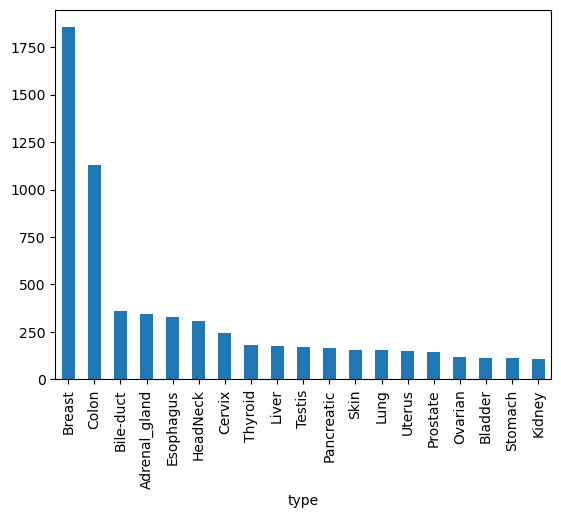

In [12]:
types_df = pd.DataFrame(train_types, columns=['type'])
types_df['type'].value_counts().plot(kind='bar')

<Axes: xlabel='type'>

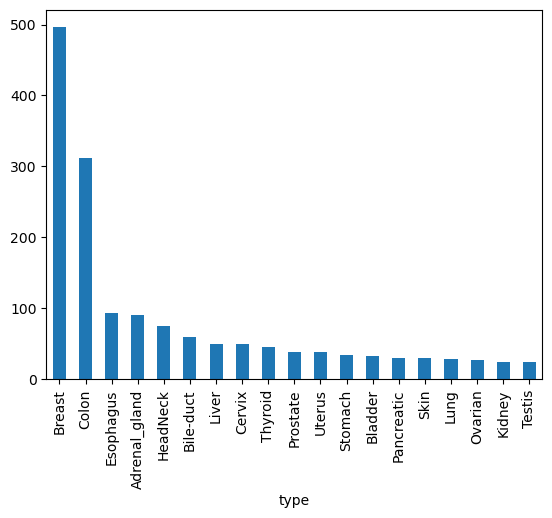

In [13]:
types_df = pd.DataFrame(test_types, columns=['type'])
types_df['type'].value_counts().plot(kind='bar')

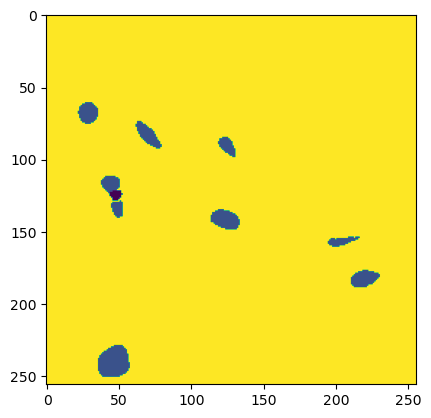

In [10]:
plt.imshow(train_masks[0])

In [15]:
np.unique(np.array(train_masks))

array([1, 2, 3, 4, 5, 6], dtype=int32)